# Analytics Project - Section 5 NoteBook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc,roc_curve, roc_auc_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# Ignore all warnings
warnings.filterwarnings("ignore")

### Read CSV

In [2]:
first_model_df = pd.read_csv('first_model_df.csv')

### Step 1: Choose and Evaluate of Different Regressors

In [3]:
def model_eval(X,y,model, poly = False, degree = -1):
    
    # Perform k-fold cross-validation
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    mse = []
    r2 = []

    # Folds
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Create a StandardScaler object
        scaler = StandardScaler()

        # Define the columns to be scaled
        columns_to_scale = ['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti', 'fico_score',
                            'max_bal_bc', 'all_util', 'bc_open_to_buy', 'tot_hi_cred_lim', 'total_bc_limit']

        # Fit the scaler on X_train and transform X_train
        X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

        # Transform X_test using the fitted scaler from X_train
        X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
        
        if poly:
            poly_features = PolynomialFeatures(degree=degree)
            X_train_poly = poly_features.fit_transform(X_train)
            X_test_poly = poly_features.transform(X_test)

            # Fit the model to the training data
            model.fit(X_train_poly, y_train)

            # Predict the target variable for the test data
            y_pred = model.predict(X_test_poly)

            mse.append(mean_squared_error(y_test,y_pred))
            r2.append(r2_score( y_test,y_pred))

        else:
            

            # Fit the model to the training data
            model.fit(X_train, y_train)

            # Predict the target variable for the test data
            y_pred = model.predict(X_test)

            mse.append(mean_squared_error(y_test,y_pred))
            r2.append(r2_score( y_test,y_pred))
        
    return np.mean(mse) , np.mean(r2)


In [4]:
# Separate the features and the target variable
X = first_model_df.drop('ann_realized_return', axis=1)
y = first_model_df['ann_realized_return']
    

results_reg = pd.DataFrame({'Linear Regression': model_eval(X,y,LinearRegression(n_jobs=-1)),
                            'polynomial regression 2nd' : model_eval(X,y,LinearRegression(), poly=True, degree =2),
                            'polynomial regression 3rd' : model_eval(X,y,LinearRegression(), poly=True, degree =3),
                            'AdaBoost': model_eval(X,y,AdaBoostRegressor())}, index = ['MSE','R_2'])


display(results_reg)

,Linear Regression,polynomial regression 2nd,polynomial regression 3rd,AdaBoost
MSE,0.007144,0.007100,1.391291e+13,0.008550
R_2,0.009930,0.016075,-1.922869e+15,-0.184616


### Step 2: Hyperparameter Optimization

In [5]:
# Split the data into training and test sets
X = first_model_df.drop('ann_realized_return', axis=1)
y = first_model_df['ann_realized_return']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def perform_polynomial_regression(X_train, X_test, y_train, y_test, degrees):
    """
    Perform polynomial regression for different degrees and evaluate the model performance with Ridge and Lasso regularization.
    Find the best alpha for each regularization technique.

    Args:
        X_train (pandas.DataFrame): The input training feature data.
        X_test (pandas.DataFrame): The input test feature data.
        y_train (pandas.Series): The training target variable.
        y_test (pandas.Series): The test target variable.
        degrees (list): List of degrees for polynomial regression.

    Returns:
        pandas.DataFrame: The model performance metrics for each polynomial degree and regularization technique.

    """
    Model_perf = pd.DataFrame(columns=['Model_Name', 'MSE', 'R2_Score', 'Regularization', 'Alpha'])

    for degree in degrees:
        # Create a PolynomialFeatures object with the specified degree
        poly = PolynomialFeatures(degree=degree)
        
        # Transform the features into polynomial features
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        # Ridge regularization
        ridge = Ridge()
        ridge_param_grid = {'alpha': [ 0.01, 0.1, 1, 10]}  # Define the alpha values to be tested
        ridge_grid_search = GridSearchCV(ridge, ridge_param_grid, scoring='neg_mean_squared_error', cv=5)
        ridge_grid_search.fit(X_train_poly, y_train)

        ridge_best_alpha = ridge_grid_search.best_params_['alpha']
        ridge_best_model = ridge_grid_search.best_estimator_
        y_pred_ridge = ridge_best_model.predict(X_test_poly)
        ridge_mse = mean_squared_error(y_test, y_pred_ridge)
        ridge_r2 = r2_score(y_test, y_pred_ridge)
        Model_perf.loc[len(Model_perf)] = [f'Polynomial Regression (degree={degree})', ridge_mse, ridge_r2,
                                           'Ridge', ridge_best_alpha]

        # Lasso regularization
        lasso = Lasso()
        lasso_param_grid = {'alpha': [ 0.01, 0.1, 1, 10]}  # Define the alpha values to be tested
        lasso_grid_search = GridSearchCV(lasso, lasso_param_grid, scoring='neg_mean_squared_error', cv=5)
        lasso_grid_search.fit(X_train_poly, y_train)

        lasso_best_alpha = lasso_grid_search.best_params_['alpha']
        lasso_best_model = lasso_grid_search.best_estimator_
        y_pred_lasso = lasso_best_model.predict(X_test_poly)
        lasso_mse = mean_squared_error(y_test, y_pred_lasso)
        lasso_r2 = r2_score(y_test, y_pred_lasso)
        Model_perf.loc[len(Model_perf)] = [f'Polynomial Regression (degree={degree})', lasso_mse, lasso_r2,
                                           'Lasso', lasso_best_alpha]

    return Model_perf

# Perform polynomial regression for different degrees and evaluate with Ridge and Lasso regularization
degrees = [2]
poly_model_performance = perform_polynomial_regression(X_train, X_test, y_train, y_test, degrees)
print(poly_model_performance)

                         Model_Name       MSE  R2_Score Regularization  Alpha
0  Polynomial Regression (degree=2)  0.007098  0.015847          Ridge   1.00
1  Polynomial Regression (degree=2)  0.007161  0.007172          Lasso   0.01


### Step 3: Classification Model Selection

In [6]:
def evaluate_classification_model(X, y, model):
        
    # a list to store the auc scores in every fold 
    f1 = []
    recall = []
    precision =[]
    auc_roc = []
    acc = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    # Perform 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    filtered_df = pd.DataFrame()  # Initialize an empty DataFrame to compile the datasets
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Create a StandardScaler object
        scaler = StandardScaler()

        # Define the columns to be scaled
        columns_to_scale = ['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti', 'fico_score',
                            'max_bal_bc', 'all_util', 'bc_open_to_buy', 'tot_hi_cred_lim', 'total_bc_limit']

        # Fit the scaler on X_train and transform X_train
        X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

        # Transform X_test using the fitted scaler from X_train
        X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

        # fit model for every fold
        model.fit(X_train,y_train)

        # predeictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        #recall, precision, f1 score
        acc.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))

        # Calculate the ROC AUC score
        roc_auc = roc_auc_score(y_test, y_proba)

        # Calculate the ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)

        auc_roc.append(auc(fpr, tpr))
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(auc(fpr, tpr))
        
        # Filter and compile the test set where y_pred == 1
        fold_dataset = X_test[y_pred == 1]
        fold_dataset['ann_realized_return'] = y.iloc[test_index][y_pred == 1]
        filtered_df = pd.concat([filtered_df, fold_dataset], ignore_index=True)

    #averages
    avg_recall = np.mean(recall)
    avg_precision = np.mean(precision)
    avg_f1 = np.mean(f1)
    avg_auc_roc = np.mean(auc_roc)
    avg_acc = np.mean(acc)

    # average ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    scores = {"F1-Score":avg_f1,
            "Auc-Roc":avg_auc_roc,
            "accuracy":avg_acc,
            "recall":avg_recall,
            "precision":avg_precision,
            "mean_fpr": mean_fpr,
            "mean_tpr": mean_tpr}

    # updte scores for every model 
    return  scores , filtered_df

In [7]:
# creating the filtered df
X = first_model_df.drop(['ann_realized_return'], axis=1)
y = (first_model_df['ann_realized_return'] > 0.02).astype(int)

results_clf = {"Logisitc Regression" : evaluate_classification_model(X, y, LogisticRegression())[0],
               "Random Forest" :evaluate_classification_model(X, y, RandomForestClassifier())[0],
               "Decision Tree" :evaluate_classification_model(X, y, DecisionTreeClassifier())[0]}

In [8]:
clf_comp = pd.DataFrame.from_dict(results_clf).iloc[:5]
display(clf_comp)

,Logisitc Regression,Random Forest,Decision Tree
F1-Score,0.903711,0.903837,0.828397
Auc-Roc,0.678569,0.66454,0.534165
accuracy,0.825007,0.824985,0.719793
recall,0.994717,0.996289,0.819266
precision,0.827961,0.827086,0.837736


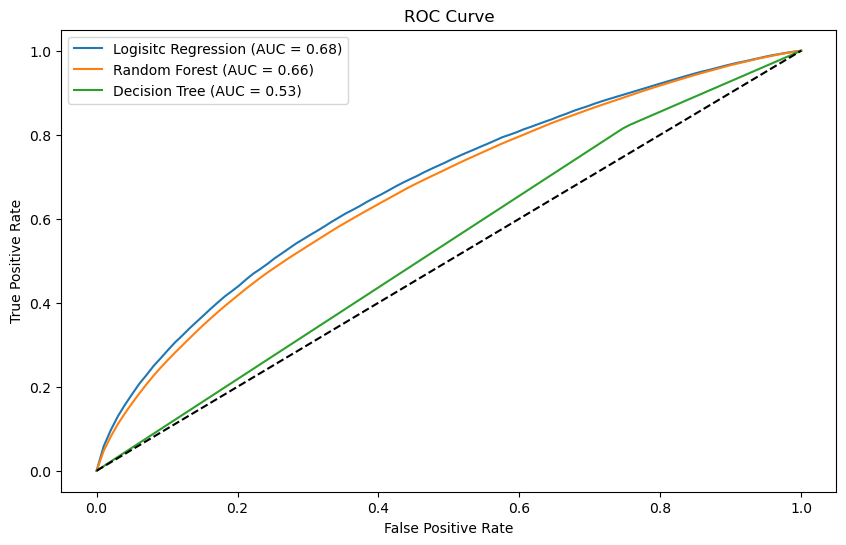

In [9]:
#ROC
fig, ax = plt.subplots(figsize = (10,6))
for clf_name in results_clf.keys():
    mean_fpr = results_clf[clf_name]['mean_fpr']
    mean_tpr = results_clf[clf_name]['mean_tpr']
    mean_auc = results_clf[clf_name]['Auc-Roc']
    ax.plot(mean_fpr, mean_tpr, label=f'{clf_name} (AUC = {mean_auc:.2f})')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend()
plt.show()

### Step 4: Filtered Data Model

In [10]:
# creating the filtered df
X = first_model_df.drop(['ann_realized_return'], axis=1)
y = (first_model_df['ann_realized_return'] > 0.02).astype(int)

#since the logistic regression was the best classification model
filtered_df_lg = evaluate_classification_model(X, y, LogisticRegression())[1]

display(filtered_df_lg)

,loan_amnt,int_rate,emp_length,annual_inc,dti,initial_list_status,application_type,max_bal_bc,all_util,bc_open_to_buy,...,home_ownership_any,home_ownership_mortgage,home_ownership_own,home_ownership_rent,purpose_home,purpose_major_purchase,purpose_other,purpose_refinance,pub_rec_binary,ann_realized_return
0,1.289317,1.019081,-1.444439,0.240366,0.639334,0,0,1.655035,-0.034066,0.945504,...,0,1,0,0,0,0,0,1,0,1
1,1.198594,0.020558,0.377247,0.991933,-0.078967,0,0,0.136397,0.369441,-0.487109,...,0,1,0,0,0,0,0,1,0,0
2,1.728963,-0.926877,1.157969,0.336350,-0.722922,0,0,0.839835,0.051387,0.902492,...,0,1,0,0,0,0,0,1,0,1
3,-0.032070,0.252773,-0.143235,-0.995821,-0.814426,0,0,-0.127418,0.883540,-1.160481,...,0,0,0,1,0,0,0,1,0,1
4,-0.750147,0.368880,1.157969,-0.807029,-0.716059,0,0,0.018497,0.174899,-0.285066,...,0,0,1,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264487,0.539202,-0.108642,-1.313401,1.395596,-0.033215,0,0,0.270541,-0.829520,0.981908,...,0,0,0,1,0,0,0,1,0,1
264488,-0.177943,-0.108642,0.378804,0.810392,-0.444460,0,0,0.134800,1.315934,-0.418383,...,0,0,0,1,0,0,0,1,0,1
264489,0.943078,0.715067,-0.922892,-0.159803,-0.907111,0,0,-0.046752,-1.472077,0.494133,...,0,0,0,1,0,1,0,0,0,1
264490,0.795163,-0.909148,-0.922892,-0.134476,1.400431,1,0,-4.426089,-0.887564,0.604171,...,0,1,0,0,0,0,0,1,0,1


### Step 5: Final regression model

In [11]:
# Separate the features and the target variable
X = filtered_df_lg.drop(['ann_realized_return'], axis=1)
y = filtered_df_lg['ann_realized_return']
    

results_reg_after_clf = pd.DataFrame({'Linear Regression': model_eval(X,y,LinearRegression(n_jobs=-1)),
                            'polynomial regression 2nd' : model_eval(X,y,LinearRegression(), poly=True, degree =2),
                            'polynomial regression 3rd' : model_eval(X,y,LinearRegression(), poly=True, degree =3),
                            'AdaBoost': model_eval(X,y,AdaBoostRegressor())}, index = ['MSE','R_2'])


display(results_reg_after_clf)

,Linear Regression,polynomial regression 2nd,polynomial regression 3rd,AdaBoost
MSE,0.134804,0.134033,2.865802e+14,0.135920
R_2,0.053622,0.059032,-2.010873e+15,0.045786
